In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220729_20 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220729_20"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220729_20", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7720480727381693]
max_auc_mean: 0.7720480727381693, max_auc_std: 0.0
max_auc_dir: 01


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7715244761702453]
max_fin_auc_mean: 0.7715244761702453, max_auc_std: 0.0
max_fin_auc_dir: 01


In [7]:
test_dataset[47]

(array([ 3,  3,  3, ..., 20, 20, 20]),
 array([2, 2, 4, ..., 2, 2, 0]),
 array([1, 1, 0, ..., 1, 1, 1]))

In [8]:
# 3, 5, 6, 7, 11, 12, 15, 20, 47
c3_seq, d_seq, r_seq = test_dataset[12]

c3_seq = [c3_seq[:seq_len]]
d_seq = [d_seq[:seq_len]]
r_seq = [r_seq[:seq_len]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C3_seq: [batch_size, seq_len, num_c4]

# beta3_seq: [batch_size, seq_len]
beta3_seq = torch.gather(C3_seq, dim=-1, index=LongTensor(c3_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta3_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta3_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

# C3_seq = C3_seq.squeeze().detach().cpu().numpy()

alpha_seq = alpha_seq.detach().cpu().numpy()
gamma_seq = gamma_seq.detach().cpu().numpy()

prev_alpha = alpha_seq[0][:-1]
prev_alpha = np.concatenate([model.init_alpha(1).detach().cpu().numpy(), prev_alpha])

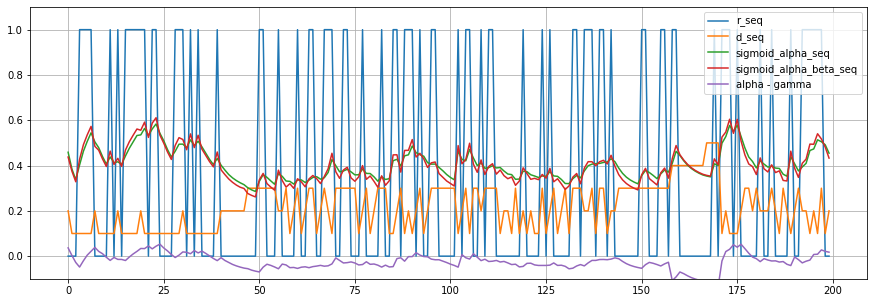

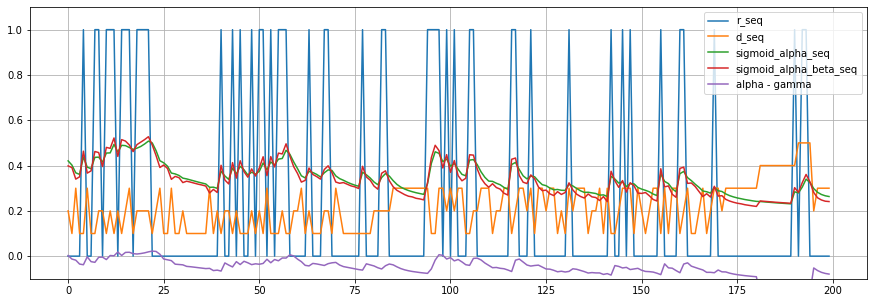

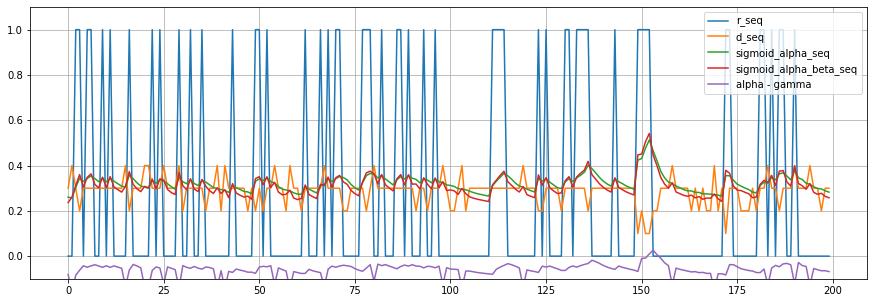

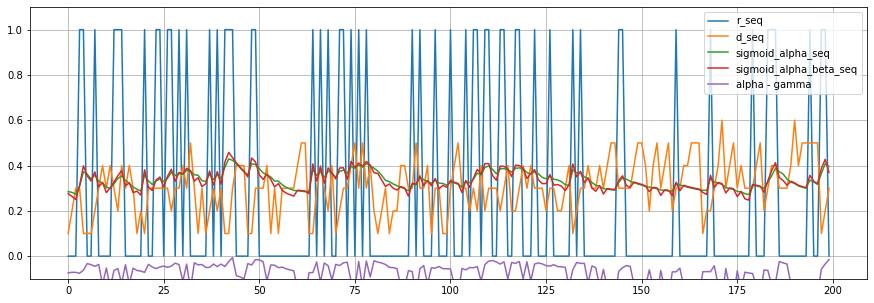

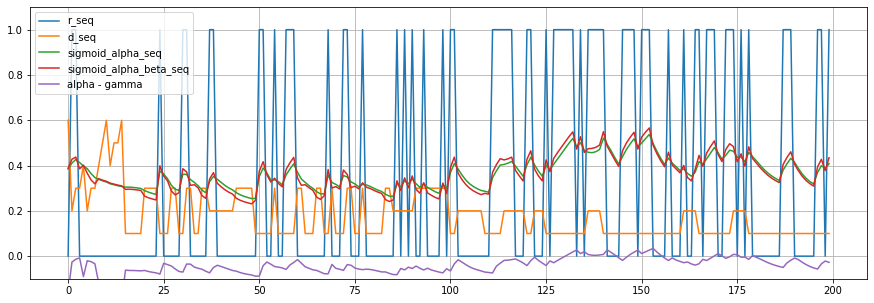

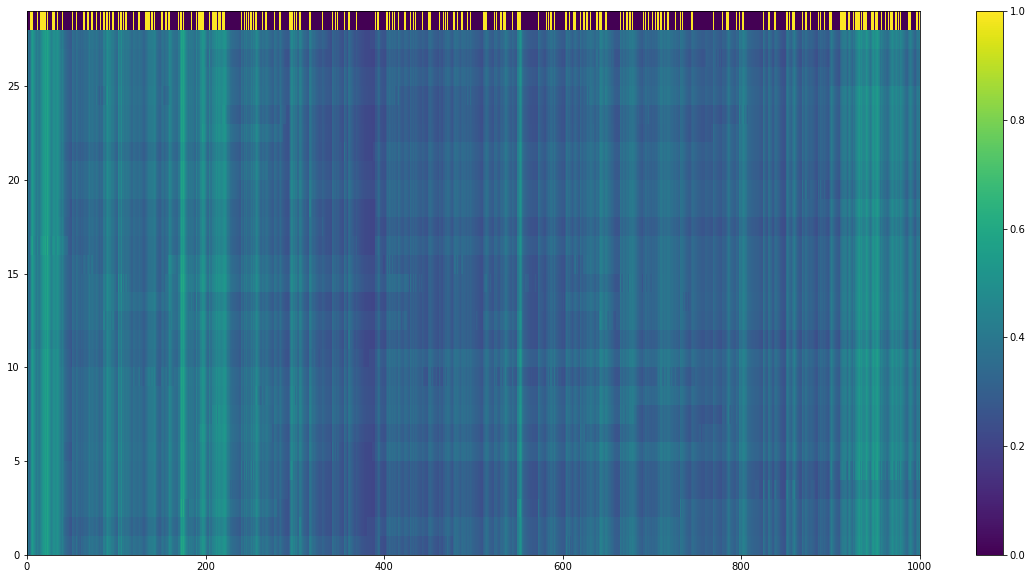

In [9]:
view_from = 0
view_range = 200

for view_from in range(0, seq_len, view_range):
    view_to = view_from + view_range

    plt.figure(figsize=[15, 5], facecolor="white")
    # plt.figure(figsize=[100, 10], facecolor="white")
    plt.plot(r_seq[0][view_from:view_to], label="r_seq")
    plt.plot(((d_seq[0] + 1) / 10)[view_from:view_to], label="d_seq")
    plt.plot(sigmoid_alpha_seq[view_from:view_to], label="sigmoid_alpha_seq")
    plt.plot(sigmoid_alpha_beta_seq[view_from:view_to], label="sigmoid_alpha_beta_seq")
    # plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_alpha_beta4_seq")
    # plt.plot(sigmoid_beta4_seq, label="sigmoid_beta4_seq")
    plt.plot(((prev_alpha - gamma_seq) / 10)[view_from:view_to], label="alpha - gamma")
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3 + 1], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [10]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.45873812, 0.45873812, 0.45873812, 0.45873812, 0.45873812,
       0.45873812, 0.45873812, 0.45873812, 0.45873812, 0.45873812,
       0.45873812, 0.43754047, 0.45873812, 0.45873812, 0.45873812,
       0.45873812, 0.45873812, 0.45873812, 0.45873812, 0.45873812,
       0.45873812, 0.45873812, 0.45873812, 0.45873812, 0.45873812,
       0.45873812, 0.45873812, 0.45873812], dtype=float32)

In [11]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.41759157, 0.4119549 , 0.4147109 , 0.3786611 , 0.43425915,
       0.4307106 , 0.4119549 , 0.4119549 , 0.42156148, 0.4119549 ,
       0.4307106 , 0.37862223, 0.4119549 , 0.4183136 , 0.41351712,
       0.4119549 , 0.4119549 , 0.37859055, 0.4119549 , 0.37859088,
       0.3971987 , 0.4119549 , 0.4119549 , 0.4119549 , 0.4204193 ,
       0.38086843, 0.38056436, 0.4119549 ], dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([ 3,  4, 10, 13, 15, 16, 18, 19, 20, 21, 25, 28, 32, 33, 34, 35, 36,
        37, 46, 51, 52, 54, 57, 58, 63, 66, 68, 69]),
 [array([28, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
         36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
         36, 46, 25, 69, 54, 36,  4, 37, 16, 54, 28, 28, 36,  4, 46, 25, 69,
         16, 54, 54, 36,  3,  3,  3,  3,  3,  3, 35, 35, 35, 35, 35, 35, 35,
         35, 35, 35, 35, 35, 35, 35, 35, 63, 63, 63, 63, 63, 63, 63, 63, 32,
         32, 32, 32, 63, 63, 63, 63, 63, 32, 32, 32, 32, 32, 32, 32, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
         21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,  3, 63,
         32, 32, 34, 21, 21, 35, 35, 63, 32, 32, 34, 32, 21, 21, 35, 34, 34,
         21, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 33, 33, 33, 33, 33,
         33, 33, 33, 33

In [13]:
dataset.c3_list[np.unique(c3_seq)]

array(['01 다항식의 연산', '01 두 점 사이의 거리', '01 복소수의 성질과 연산', '01 삼차방정식과 사차방정식',
       '01 연립일차부등식', '01 원의 방정식', '01 이차방정식', '01 이차방정식과 이차함수의 관계',
       '01 이차부등식', '01 인수분해', '01 직선의 방정식', '01 평행이동', '01 항등식',
       '02 i의 거듭제곱, 음수의 제곱근', '02 나머지정리와 인수정리', '02 다항식의 곱셈공식', '02 대칭이동',
       '02 두 직선의 위치 관계', '02 선분의 내분점과 외분점', '02 연립이차방정식', '02 연립이차부등식',
       '02 원과 직선의 위치 관계', '02 이차방정식의 판별식', '02 이차함수의 최대, 최소',
       '03 다항식의 나눗셈', '03 부정방정식', '03 이차방정식의 근과 계수의 관계',
       '03 점과 직선 사이의 거리'], dtype=object)

In [14]:
dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]

'02 두 직선의 위치 관계'

In [15]:
dataset.c32c4_list[dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]]

['[10] 한 직선에 평행 또는 수직인 직선의 방정식',
 '[11] 선분의 수직이등분선의 방정식',
 '[12] 세 직선의 위치 관계',
 '[9] 두 직선의 위치 관계']

In [16]:
d_seq

[array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 1, 2, 0, 1, 2, 2, 0,
        1, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2,
        0, 1, 0, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 1, 2,
        2, 2, 2, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 0, 1, 2, 0,
        2, 2, 2, 1, 1, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0,
        1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 2,
        0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1,
        1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 1,
        0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 

In [17]:
model.D.weight

Parameter containing:
tensor([[-0.1918],
        [-0.2084],
        [-0.2203],
        [ 0.5497],
        [ 0.9755],
        [ 1.1844],
        [ 1.8303]], requires_grad=True)

In [18]:
model.init_alpha

<bound method UserModel.init_alpha of UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)>